**Import Libraries**

In [35]:
# ============================== IMPORT LIBRARIES ==============================
import os
import cv2
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau



**Import and Split Data**

In [36]:
# ============================== CONFIGURE GPU USAGE ==============================
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # ตั้งค่าให้ TensorFlow ใช้ GPU โดยไม่กิน RAM เกินจำเป็น
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found! Training on CPU.")

# ============================== SET PARAMETERS ==============================
path = "Dataset"              # Path to dataset
labelFile = 'labels.csv'      # CSV file containing labels
batch_size_val = 32
epochs_val = 30
imageDimesions = (32, 32, 3)
testRatio = 0.1               # Test dataset ratio
validationRatio = 0.2         # Validation dataset ratio

# ============================== LOAD IMAGES & LABELS ==============================
print("Loading Dataset...")
images, classNo = [], []
myList = os.listdir(path)
noOfClasses = len(myList)
print(f"Total Classes Detected: {noOfClasses}")

for count, class_name in enumerate(myList):
    myPicList = os.listdir(os.path.join(path, str(count)))
    for img_name in myPicList:
        curImg = cv2.imread(os.path.join(path, str(count), img_name))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
print("\nData Imported Successfully.")

# Convert lists to numpy arrays
images = np.array(images)
classNo = np.array(classNo)

# ============================== SPLIT DATASET ==============================
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# Display dataset shapes
print("Data Shapes")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_validation.shape}, {y_validation.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# ============================== READ LABEL DATA ==============================
data = pd.read_csv(labelFile)
print(f"Label Data Shape: {data.shape}, Type: {type(data)}")

# ============================== IMAGE PREPROCESSING ==============================
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def equalize(img):
    return cv2.equalizeHist(img)

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255  # Normalize to range 0-1
    return img

# Apply preprocessing
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# ============================== IMAGE DATA AUGMENTATION ==============================
dataGen = ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, shear_range=0.1, rotation_range=10
)
dataGen.fit(X_train)

# ============================== CONVERT LABELS TO CATEGORICAL ==============================
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


Num GPUs Available: 0
No GPU found! Training on CPU.
Loading Dataset...
Total Classes Detected: 43
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Data Imported Successfully.
Data Shapes
Train: (52660, 32, 32, 3), (52660,)
Validation: (13165, 32, 32, 3), (13165,)
Test: (7314, 32, 32, 3), (7314,)
Label Data Shape: (43, 2), Type: <class 'pandas.core.frame.DataFrame'>


**Sample Images of Dataset**

In [37]:

labels = pd.read_csv("labels.csv")
sub_directories = os.listdir(path)

# Finding number of classes in the data
print("Number of Classes: ",len(sub_directories))

# Finding number of images under each class
no_of_images = []
for directory in sub_directories:
    no_of_images.append(len(os.listdir(os.path.join(path, directory))))

labels["n_samples"] = no_of_images
labels.sort_values(["n_samples"], inplace=True)

# Displaying DataFrame containing class name, directory name and number of samples 
display(labels)

Number of Classes:  43


,ClassId,Name,n_samples
11,11,Right-of-way at the next intersection,390
31,31,Wild animals crossing,390
20,20,Dangerous curve to the right,450
37,37,Go straight or left,450
36,36,Go straight or right,450
26,26,Traffic signals,450
0,0,Speed limit (20km/h),451
22,22,Bumpy road,510
17,17,No entry,510
33,33,Turn right ahead,570


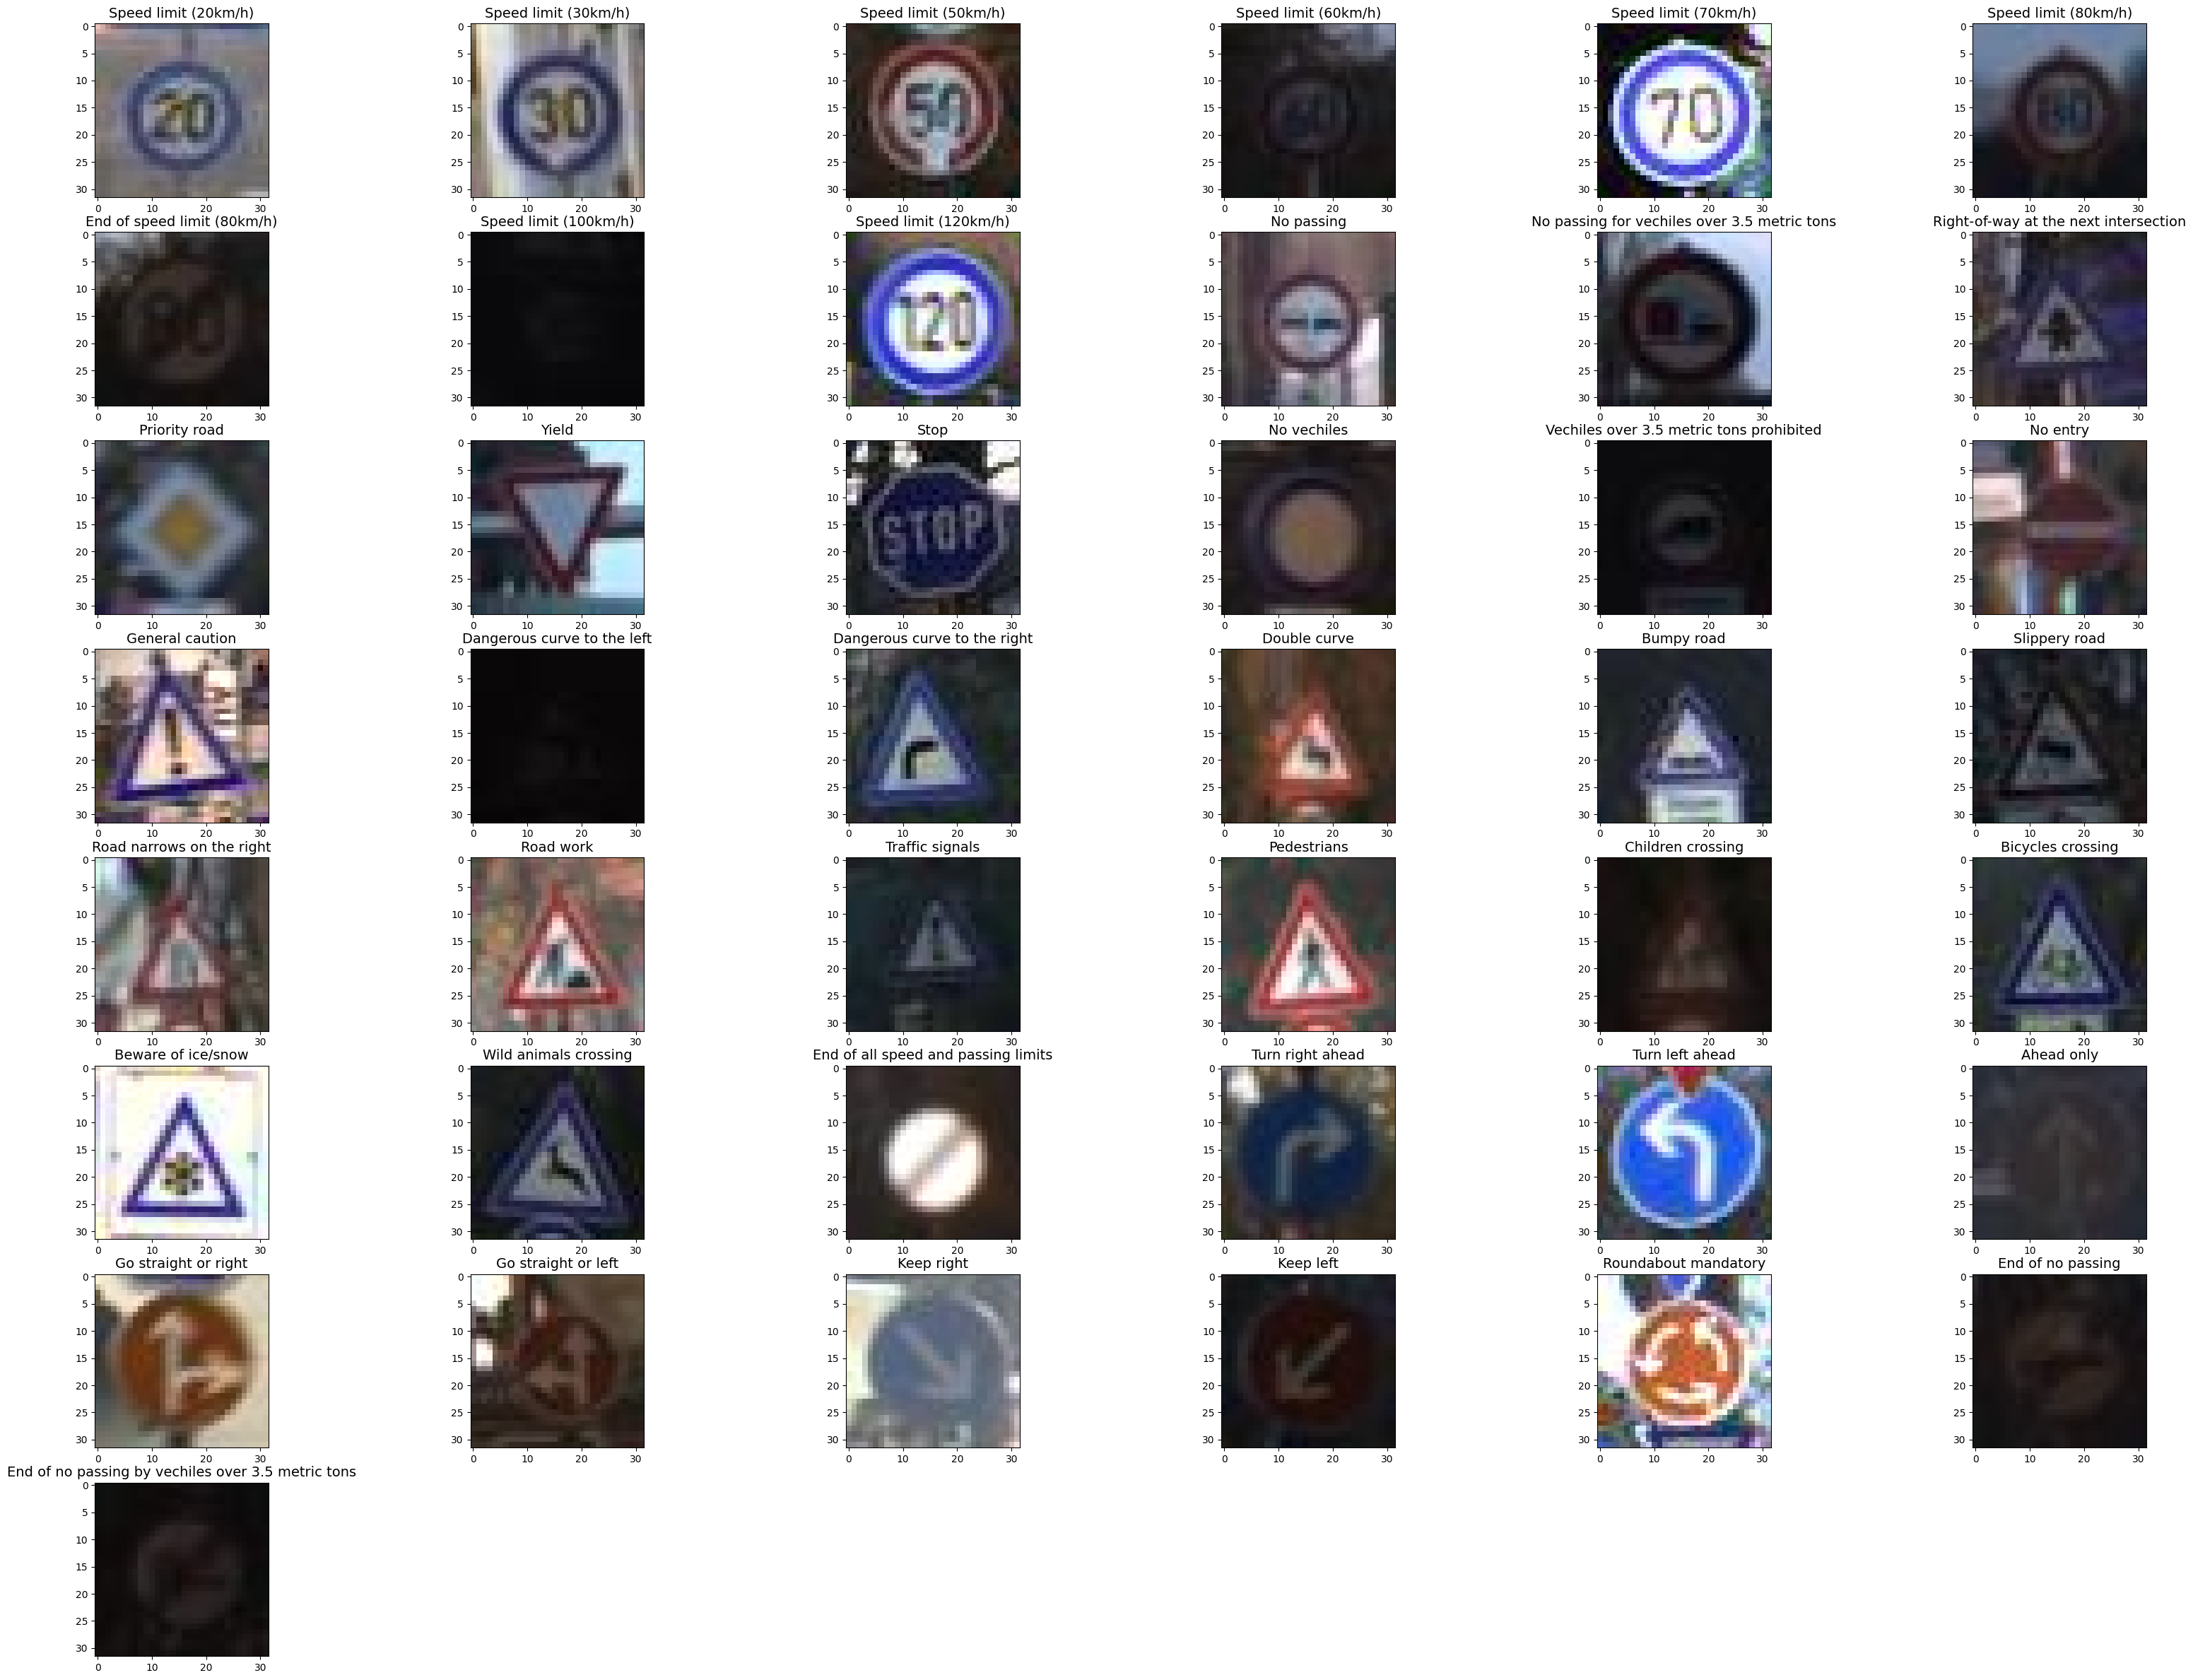

In [38]:
import random

# displaying some images randomly from each class
fig = plt.figure(figsize=(40, 30))
rows = 8
cols = 6

for directory in sub_directories:
    current_dir_files = os.listdir(os.path.join(path, directory))
    
    # แก้ไขตรงนี้: เพิ่มค่าต่ำสุดเป็น 0 และค่ามากสุดต้องเป็น len(current_dir_files) - 1
    random_index = random.randint(0, len(current_dir_files) - 1)
    
    img = cv2.imread(os.path.join(path, directory, current_dir_files[random_index]))
    
    fig.add_subplot(rows, cols, int(directory) + 1)
    plt.imshow(img)
    plt.title(labels["Name"][int(directory)], fontsize=14)

plt.show()


**Defining and Compiling the model**

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_21 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_55 (Conv2D)          (None, 24, 24, 64)        102464    
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 10, 10, 32)        18464     
                                                                 
 batch_normalization_22 (Ba  (None, 10, 10, 32)      

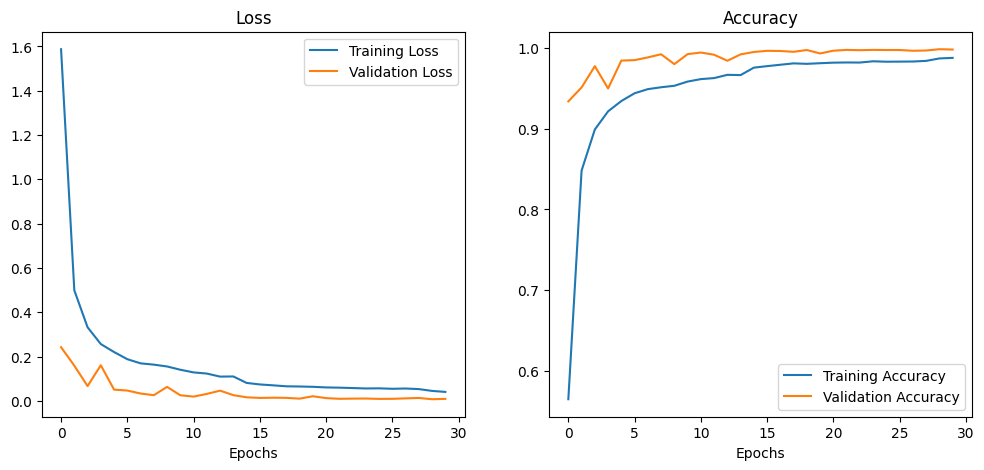

Test Score: 0.010030186735093594
Test Accuracy: 0.9965819120407104
Model Saved Successfully.


c:\Users\wator\Documents\Ananto\project\miniproject\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:

# ============================== BUILD CNN MODEL ==============================
def myModel():
    model = Sequential()

    # Convolutional Layers
    model.add(Conv2D(64, (5,5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================== TRAIN MODEL ==============================
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # ลด learning rate ถ้า val_loss ไม่ลดลง
    factor=0.5,           # ลดค่า learning rate ลง 50%
    patience=3,           # ถ้า val_loss ไม่ลดลงติดต่อกัน 3 epochs
    min_lr=1e-6,          # กำหนดค่า learning rate ต่ำสุด
    verbose=1
)
model = myModel()

model.summary()

history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=len(X_train) // batch_size_val,
    epochs=epochs_val,
    validation_data=(X_validation, y_validation),
    shuffle=True,
    callbacks=[lr_scheduler]
    )

# ============================== PLOT TRAINING HISTORY ==============================
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

# ============================== EVALUATE MODEL ==============================
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Score: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# ============================== SAVE MODEL ==============================
model.save("model.h5")
print("Model Saved Successfully.")


**Visualising Model Architecture**

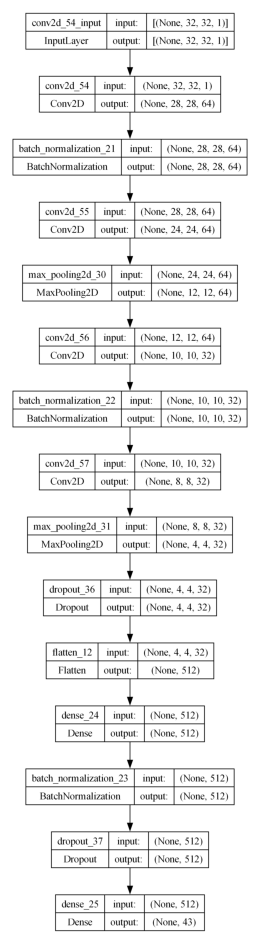

In [40]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

#โหลดโมเดลจากไฟล์ model.h5
model = load_model("model.h5")

# สร้างภาพโครงสร้างโมเดล
plot_model(model, to_file="model.png", show_layer_names=True, show_shapes=True, dpi=350)

# แสดงภาพโมเดล
img = Image.open("model.png")
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()
